Ep1: VStd T192.51/E150.46 | CVaR T245.86/E197.39
Ep2: VStd T140.06/E130.47 | CVaR T187.46/E171.94
Ep3: VStd T126.60/E121.73 | CVaR T168.55/E159.12
Ep4: VStd T120.56/E117.25 | CVaR T158.63/E151.64
Ep5: VStd T116.86/E114.45 | CVaR T152.89/E147.09
Ep6: VStd T114.39/E112.42 | CVaR T149.15/E143.93
Ep7: VStd T112.71/E111.20 | CVaR T146.38/E141.83
Ep8: VStd T111.46/E110.09 | CVaR T144.15/E140.04
Ep9: VStd T110.44/E109.28 | CVaR T142.33/E138.14
Ep10: VStd T109.58/E108.36 | CVaR T140.81/E136.86
Ep11: VStd T108.85/E107.75 | CVaR T139.42/E136.13
Ep12: VStd T108.24/E107.47 | CVaR T138.23/E135.25
Ep13: VStd T107.70/E106.82 | CVaR T137.10/E133.74
Ep14: VStd T107.25/E106.46 | CVaR T136.31/E133.49
Ep15: VStd T106.79/E105.93 | CVaR T135.43/E132.93
Ep16: VStd T106.42/E105.71 | CVaR T134.72/E132.17
Ep17: VStd T106.08/E105.33 | CVaR T134.06/E131.68
Ep18: VStd T105.74/E105.10 | CVaR T133.37/E130.58
Ep19: VStd T105.44/E104.83 | CVaR T132.84/E130.52
Ep20: VStd T105.19/E104.69 | CVaR T132.23/E130.32
Ep21: VSt

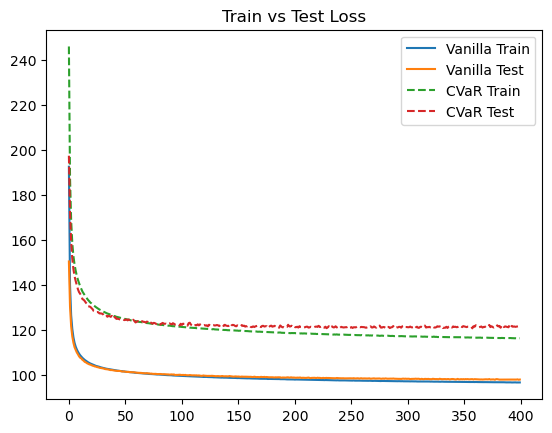

Mean/90th Loss Vanilla: 0.09314211 0.1252444684505463
Mean/90th Loss CVaR:    0.10020981 0.12041710093617439
Mean/10th PSNR Vanilla: 10.506903 9.022414302825927
Mean/10th PSNR CVaR:    10.067415 9.193118572235107
Per-class MSE Vanilla: {0: 0.0127228545, 1: 0.0048273606, 2: 0.013480143, 3: 0.012132858, 4: 0.010902918, 5: 0.01295598, 6: 0.011084862, 7: 0.008931759, 8: 0.01431931, 9: 0.00933837}
Per-class MSE CVaR:    {0: 0.011759, 1: 0.013594882, 2: 0.0131908115, 3: 0.0126349, 4: 0.013286441, 5: 0.013267575, 6: 0.0128212795, 7: 0.012960257, 8: 0.013128216, 9: 0.012300773}


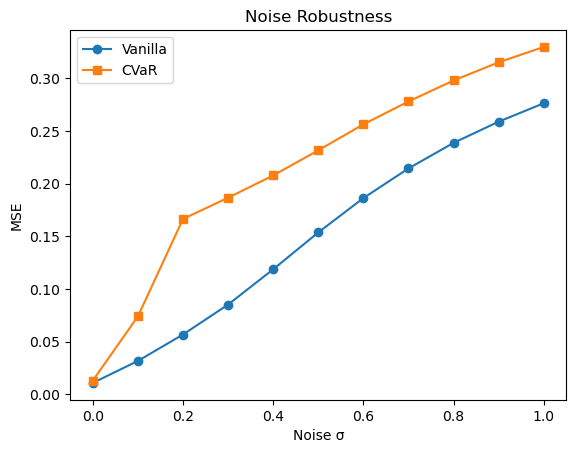

Top worst reconstructions - Vanilla


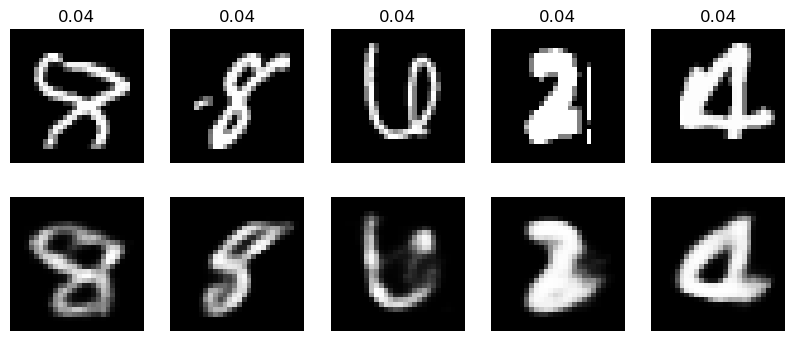

Top worst reconstructions - CVaR


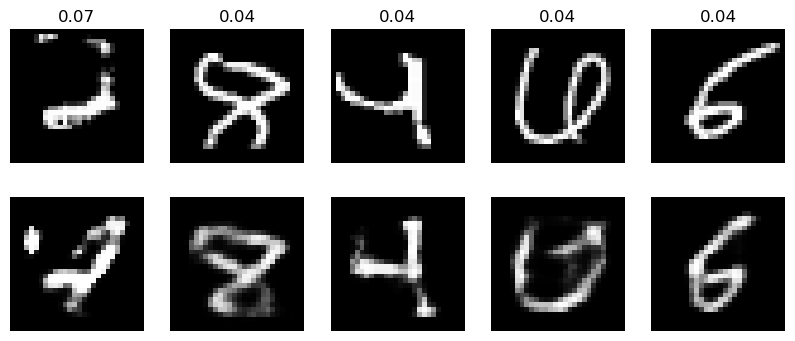

(-0.5, 241.5, 241.5, -0.5)

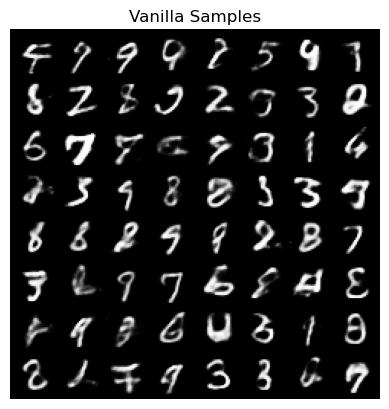

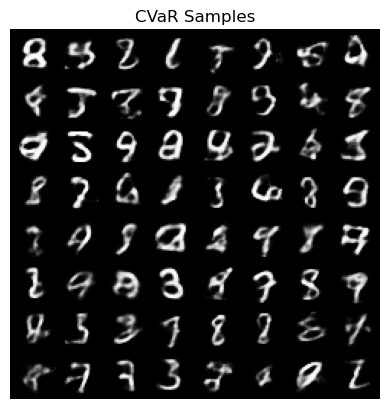

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# ---------- Hyperparameters ----------
batch_size      = 32
lr_vae          = 1e-4
epochs          = 400
latent_dim      = 20
alpha           = 0.8    # tail fraction for CVaR
imbalance_ratio = 0.1
minority_classes = [0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_pixels = 28*28

# ---------- CVaR (Superquantile) ----------
def superquantile(losses, alpha=0.9):
    q = torch.quantile(losses, alpha)
    tail = losses[losses >= q]
    return tail.mean() if tail.numel()>0 else q

# ---------- Imbalanced MNIST Loader ----------
def get_imbalanced_mnist(train=True):
    ds = datasets.MNIST(root='./data', train=train, download=True,
                        transform=transforms.ToTensor())
    targets = ds.targets
    idxs = []
    for c in range(10):
        mask = (targets==c).nonzero(as_tuple=True)[0]
        if c in minority_classes:
            k = int(len(mask)*imbalance_ratio)
            sel = mask[torch.randperm(len(mask))[:k]]
            idxs.append(sel)
        else:
            idxs.append(mask)
    subset = Subset(ds, torch.cat(idxs))
    return DataLoader(subset, batch_size=batch_size, shuffle=train, num_workers=0, drop_last=False)

# ---------- VAE Model ----------
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

# ---------- Training & Eval Functions ----------
def train_standard(model, loader, optimizer):
    model.train(); total=0
    for data, _ in loader:
        x = data.view(-1, num_pixels).to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        recon_loss = F.binary_cross_entropy(recon, x, reduction='mean') * num_pixels
        kl = (-0.5*(1 + logvar - mu.pow(2) - logvar.exp()).sum(1)).mean()
        loss = recon_loss + kl
        loss.backward(); optimizer.step()
        total += loss.item()
    return total/len(loader)

def eval_standard(model, loader):
    model.eval(); total=0
    with torch.no_grad():
        for data, _ in loader:
            x = data.view(-1, num_pixels).to(device)
            recon, mu, logvar = model(x)
            recon_loss = F.binary_cross_entropy(recon, x, reduction='mean') * num_pixels
            kl = (-0.5*(1 + logvar - mu.pow(2) - logvar.exp()).sum(1)).mean()
            total += (recon_loss+kl).item()
    return total/len(loader)

def train_cvar(model, loader, optimizer, alpha):
    model.train(); total=0
    for data, _ in loader:
        x = data.view(-1, num_pixels).to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        per = F.binary_cross_entropy(recon, x, reduction='none').mean(dim=1)*num_pixels
        cvar_recon = superquantile(per, alpha)
        kl = (-0.5*(1 + logvar - mu.pow(2) - logvar.exp()).sum(1)).mean()
        loss = cvar_recon + kl
        loss.backward(); optimizer.step()
        total += loss.item()
    return total/len(loader)

def eval_cvar(model, loader, alpha):
    model.eval(); total=0
    with torch.no_grad():
        for data, _ in loader:
            x = data.view(-1, num_pixels).to(device)
            recon, mu, logvar = model(x)
            per = F.binary_cross_entropy(recon, x, reduction='none').mean(dim=1)*num_pixels
            cvar_recon = superquantile(per, alpha)
            kl = (-0.5*(1 + logvar - mu.pow(2) - logvar.exp()).sum(1)).mean()
            total += (cvar_recon+kl).item()
    return total/len(loader)

# ---------- Metrics on Test Set ----------
def compute_recon_losses(model, loader):
    model.eval(); losses=[]
    with torch.no_grad():
        for data, _ in loader:
            x = data.view(-1, num_pixels).to(device)
            recon, _, _ = model(x)
            per = F.binary_cross_entropy(recon, x, reduction='none').mean(dim=1).cpu().numpy()
            losses.extend(per)
    return np.array(losses)

def compute_psnr(mse):
    return -10 * np.log10(mse)

def per_class_loss(model, loader):
    model.eval(); losses, labels=[],[]
    with torch.no_grad():
        for data, targets in loader:
            x = data.view(-1, num_pixels).to(device)
            recon, _, _ = model(x)
            per = F.mse_loss(recon, x, reduction='none').mean(dim=1).cpu().numpy()
            losses.extend(per); labels.extend(targets.numpy())
    losses, labels = np.array(losses), np.array(labels)
    return {c: losses[labels==c].mean() for c in range(10)}

def noise_robustness(model, loader, noise_levels):
    model.eval(); avg=[]
    with torch.no_grad():
        for sigma in noise_levels:
            vals=[]
            for data, _ in loader:
                noisy = (data + sigma*torch.randn_like(data)).clamp(0,1)
                x = noisy.view(-1, num_pixels).to(device)
                recon, _, _ = model(x)
                vals.extend(F.mse_loss(recon, x, reduction='none').mean(dim=1).cpu().numpy())
            avg.append(np.mean(vals))
    return avg

def show_worst(model, loader, k=5):
    model.eval(); worst=[]
    with torch.no_grad():
        for data, _ in loader:
            x = data.view(-1, num_pixels).to(device)
            recon, _, _ = model(x)
            per = F.mse_loss(recon, x, reduction='none').mean(dim=1)
            for i, loss in enumerate(per.cpu().numpy()):
                worst.append((loss, data[i], recon[i].cpu().view(1,28,28)))
    worst.sort(reverse=True, key=lambda t: t[0])
    fig, ax = plt.subplots(2,k,figsize=(k*2,4))
    for i in range(k):
        l, orig, rec = worst[i]
        ax[0,i].imshow(orig.squeeze(),cmap='gray'); ax[0,i].set_title(f"{l:.2f}"); ax[0,i].axis('off')
        ax[1,i].imshow(rec.squeeze(),cmap='gray'); ax[1,i].axis('off')
    plt.show()

# ---------- Main Training & Metrics ----------
train_loader = get_imbalanced_mnist(True)
test_loader  = get_imbalanced_mnist(False)

# Initialize models
vae_std = VAE().to(device); opt_std = optim.Adam(vae_std.parameters(), lr=lr_vae)
vae_cvar = VAE().to(device); opt_cvar = optim.Adam(vae_cvar.parameters(), lr=lr_vae)

# Track train/test loss
ts, vs, tc, vc = [], [], [], []
for ep in range(epochs):
    ts.append(train_standard(vae_std, train_loader, opt_std))
    vs.append(eval_standard(vae_std, test_loader))
    tc.append(train_cvar(vae_cvar, train_loader, opt_cvar, alpha))
    vc.append(eval_cvar(vae_cvar, test_loader, alpha))
    print(f"Ep{ep+1}: VStd T{ts[-1]:.2f}/E{vs[-1]:.2f} | CVaR T{tc[-1]:.2f}/E{vc[-1]:.2f}")

# Plot train/test loss
plt.figure()
plt.plot(ts, label='Vanilla Train'); plt.plot(vs, label='Vanilla Test')
plt.plot(tc, '--', label='CVaR Train'); plt.plot(vc, '--', label='CVaR Test')
plt.legend(); plt.title('Train vs Test Loss'); plt.show()

# Compute additional metrics
loss_std = compute_recon_losses(vae_std, test_loader)
loss_cvar = compute_recon_losses(vae_cvar, test_loader)
print("Mean/90th Loss Vanilla:", loss_std.mean(), np.percentile(loss_std,90))
print("Mean/90th Loss CVaR:   ", loss_cvar.mean(), np.percentile(loss_cvar,90))

psnr_std = compute_psnr(loss_std)
psnr_cvar = compute_psnr(loss_cvar)
print("Mean/10th PSNR Vanilla:", psnr_std.mean(), np.percentile(psnr_std,10))
print("Mean/10th PSNR CVaR:   ", psnr_cvar.mean(), np.percentile(psnr_cvar,10))

print("Per-class MSE Vanilla:", per_class_loss(vae_std, test_loader))
print("Per-class MSE CVaR:   ", per_class_loss(vae_cvar, test_loader))

noise_levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nr_std = noise_robustness(vae_std, test_loader, noise_levels)
nr_cvar = noise_robustness(vae_cvar, test_loader, noise_levels)
plt.plot(noise_levels, nr_std, 'o-', label='Vanilla'); plt.plot(noise_levels, nr_cvar, 's-', label='CVaR')
plt.xlabel('Noise σ'); plt.ylabel('MSE'); plt.legend(); plt.title('Noise Robustness'); plt.show()

print("Top worst reconstructions - Vanilla")
show_worst(vae_std, test_loader)
print("Top worst reconstructions - CVaR")
show_worst(vae_cvar, test_loader)

# Generate samples
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    imgs_std = vae_std.decode(z).cpu().view(-1,1,28,28)
    imgs_cvar = vae_cvar.decode(z).cpu().view(-1,1,28,28)
grid_std = vutils.make_grid(imgs_std, nrow=8, normalize=True)
grid_cvar = vutils.make_grid(imgs_cvar, nrow=8, normalize=True)
plt.figure(); plt.imshow(grid_std.permute(1,2,0)); plt.title('Vanilla Samples'); plt.axis('off')
plt.figure(); plt.imshow(grid_cvar.permute(1,2,0)); plt.title('CVaR Samples'); plt.axis('off')


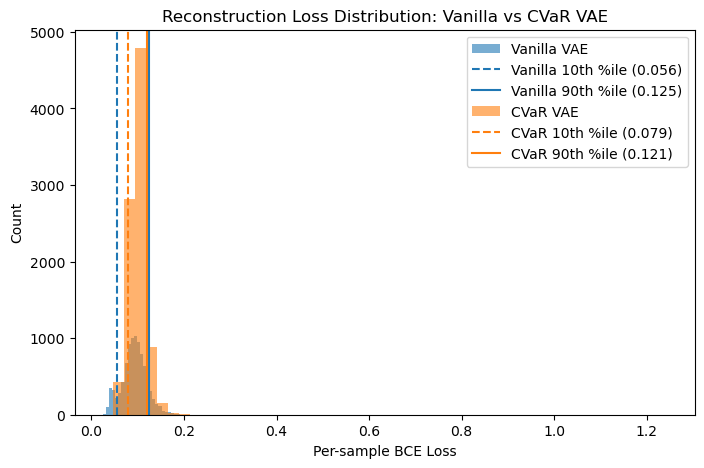

In [16]:

# ---------- Compute Per-Sample BCE Losses ----------
def get_losses(model, loader, device):
    """
    Returns a numpy array of per-sample reconstruction BCE losses (averaged per pixel).
    """
    model.eval()
    losses = []
    with torch.no_grad():
        for data, _ in loader:
            x = data.view(data.size(0), -1).to(device)
            recon, _, _ = model(x)
            # per-pixel BCE, then average per sample
            per = F.binary_cross_entropy(recon, x, reduction='none').mean(dim=1)
            losses.extend(per.cpu().numpy())
    return np.array(losses)

# Assuming vae_std, vae_cvar, test_loader, and device are already defined:

loss_std  = get_losses(vae_std,  test_loader, device)
loss_cvar = get_losses(vae_cvar, test_loader, device)

# ---------- Compute Percentiles ----------
p10_std, p90_std   = np.percentile(loss_std,  [10, 90])
p10_cvar, p90_cvar = np.percentile(loss_cvar, [10, 90])

# ---------- Plotting ----------
plt.figure(figsize=(8,5))
bins = 50

# Vanilla VAE histogram
plt.hist(loss_std,  bins=bins, alpha=0.6, label='Vanilla VAE', color='C0')
plt.axvline(p10_std, color='C0', linestyle='--', label=f'Vanilla 10th %ile ({p10_std:.3f})')
plt.axvline(p90_std, color='C0', linestyle='-',  label=f'Vanilla 90th %ile ({p90_std:.3f})')

# CVaR VAE histogram
plt.hist(loss_cvar, bins=bins, alpha=0.6, label='CVaR VAE', color='C1')
plt.axvline(p10_cvar, color='C1', linestyle='--', label=f'CVaR 10th %ile ({p10_cvar:.3f})')
plt.axvline(p90_cvar, color='C1', linestyle='-',  label=f'CVaR 90th %ile ({p90_cvar:.3f})')

plt.xlabel('Per-sample BCE Loss')
plt.ylabel('Count')
plt.title('Reconstruction Loss Distribution: Vanilla vs CVaR VAE')
plt.legend()
plt.show()

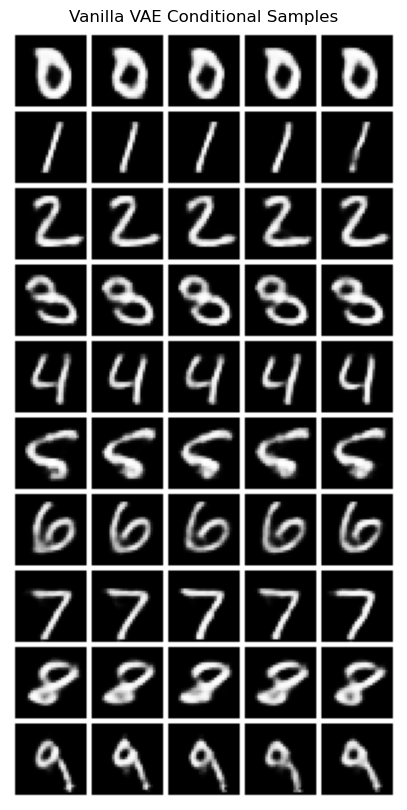

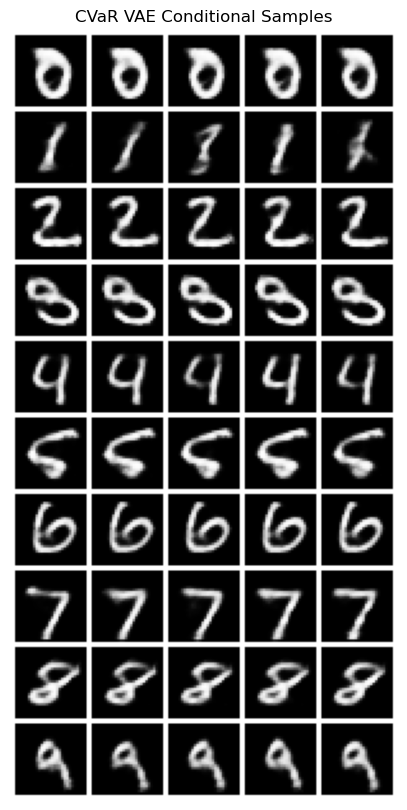

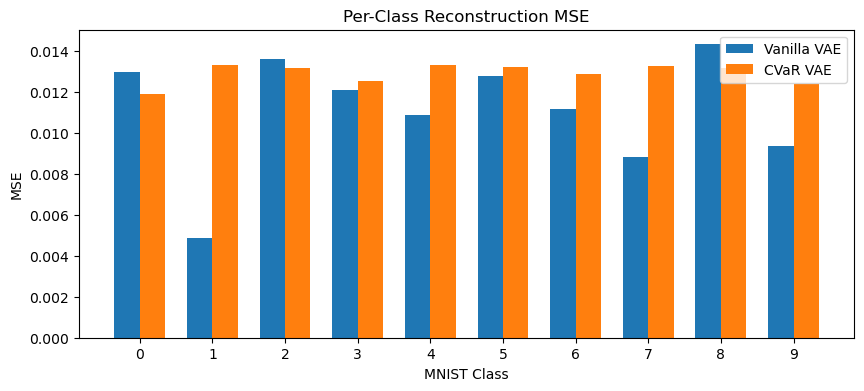

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# ---------- Helper Functions ----------

def conditional_grid(vae, class_examples, n_samples=5, title=''):
    vae.eval()
    rows = []
    with torch.no_grad():
        for c in range(10):
            x = class_examples[c].to(device)
            x_flat = x.view(1, -1)
            mu, logvar = vae.encode(x_flat)
            std = torch.exp(0.5 * logvar)
            samples = []
            for _ in range(n_samples):
                z = mu + std * torch.randn_like(std)
                rec = vae.decode(z).view(1,1,28,28)
                samples.append(rec.cpu())
            rows.append(torch.cat(samples, dim=0))
    grid = vutils.make_grid(torch.cat(rows), nrow=n_samples, normalize=True, pad_value=1)
    plt.figure(figsize=(n_samples,10))
    plt.imshow(grid.permute(1,2,0), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def per_class_mse(model, loader):
    model.eval()
    losses, labels = [], []
    with torch.no_grad():
        for data, targets in loader:
            x = data.view(data.size(0), -1).to(device)
            recon, _, _ = model(x)
            mse_per = F.mse_loss(recon, x, reduction='none').mean(dim=1)
            losses.extend(mse_per.cpu().numpy())
            labels.extend(targets.numpy())
    losses = np.array(losses); labels = np.array(labels)
    return {c: float(losses[labels==c].mean()) for c in np.unique(labels)}

# ---------- Prepare class examples ----------

class_examples = {}
for data, targets in test_loader:
    for img, label in zip(data, targets):
        c = label.item()
        if c not in class_examples:
            class_examples[c] = img.unsqueeze(0)
    if len(class_examples) == 10:
        break

# ---------- Plot Conditional Samples ----------

conditional_grid(vae_std,  class_examples, title='Vanilla VAE Conditional Samples')
conditional_grid(vae_cvar, class_examples, title='CVaR VAE Conditional Samples')

# ---------- Plot Per-Class Loss ----------

mse_std  = per_class_mse(vae_std,  test_loader)
mse_cvar = per_class_mse(vae_cvar, test_loader)

classes = sorted(mse_std.keys())
vals_std  = [mse_std[c] for c in classes]
vals_cvar = [mse_cvar[c] for c in classes]

import numpy as np
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - width/2, vals_std,  width, label='Vanilla VAE')
plt.bar(x + width/2, vals_cvar, width, label='CVaR VAE')
plt.xticks(x, classes)
plt.xlabel('MNIST Class')
plt.ylabel('MSE')
plt.title('Per-Class Reconstruction MSE')
plt.legend()
plt.show()
